In [1]:
import numpy as np
import pandas as pd
import errno
import os
from scipy.special import lambertw as W_L
from tqdm import tqdm
import matplotlib.pyplot as plt

In [60]:
kB = 0.001987204259

### TODO: readin input files for anchor strength and position side Nbulk Pbulk bind via input files (subtract anchor strengths and non-zero ones need to be calculated)
class ConvFE_contrib():
    def __init__(self, sysAfile, sysBfile, k, ref_cv, colA, colB, contrib='FE_AB', pi_crit=0.5, T=300):
        self.sysAfile = sysAfile
        self.sysBfile = sysBfile
        self.k = k
        self.ref_cv = ref_cv
        self.colA = colA
        self.colB = colB
        self.contrib = contrib
        self.pi_crit = pi_crit
        self.T = T
        self.beta = 1/(kB * T)
        self.read_sampling_data()
    
    def read_sampling_data(self):
        print('The input data is read from {} and {}. This can take a few seconds...'.format(self.sysAfile, self.sysBfile))
        A_samples = np.loadtxt(self.sysAfile, usecols=self.colA)
        B_samples = np.loadtxt(self.sysBfile, usecols=self.colB)
        print('Done!!\n')
            
        setattr(self, 'A_samples', A_samples)
        setattr(self, 'B_samples', B_samples)
    
    
    def zwanzig_formula(self,b=None,e=None):
        '''Convention: A is the 'unperturbed' system and B is the 'perturbed' system. Only harmonic restraint Potentials are allowed as a method of perturbation'''
        
        W_AB =  self.k * (self.ref_cv - self.A_samples[b:e])**2
        W_BA = -self.k * (self.ref_cv - self.B_samples[b:e])**2
        
        avgBoltzF_AB = np.mean(np.exp( -self.beta*W_AB ))
        avgBoltzF_BA = np.mean(np.exp( -self.beta*W_BA ))
        
        FE_AB = -kB*self.T*np.log( avgBoltzF_AB )
        FE_BA = -kB*self.T*np.log( avgBoltzF_BA )

        return FE_AB,FE_BA,W_AB,W_BA
    
    def calc_PiScore(self,b=None,e=None):
        FE_AB, FE_BA, W_AB, W_BA = self.zwanzig_formula(b,e)
        
        avgW_AB = np.sum(W_AB) / W_AB.size
        avgW_BA = np.sum(W_BA) / W_BA.size
        
        s_A = self.beta * (avgW_AB - FE_BA)
        s_B = self.beta * (FE_AB - avgW_BA)
        
        Pi_AB = np.sqrt((s_A/s_B) * W_L(1/(2*np.pi) * (W_AB.size-1)**2)) - np.sqrt(2*s_A)
        Pi_BA = np.sqrt((s_B/s_A) * W_L(1/(2*np.pi) * (W_BA.size-1)**2)) - np.sqrt(2*s_B)
        
        return (Pi_AB,Pi_BA)        

In [62]:
pmd_ = '../_sim/01_TIP3P_med_site/_output/pmd_.txt'
pmd_p = '../_sim/01_TIP3P_med_site/_output/pmd_p.txt'
_p = ConvFE_contrib(pmd_,pmd_p, 10.0/169/2, 1.0, 1, 1)
FE_AB, FE_BA, _,_ = _p.zwanzig_formula()
print(FE_AB,FE_BA)

The input data is read from ../_sim/01_TIP3P_med_site/_output/pmd_.txt and ../_sim/01_TIP3P_med_site/_output/pmd_p.txt. This can take a few seconds...
Done!!

0.08428412230106543 -0.038877227827697834


In [63]:
pmd_ = '../_sim/01_TIP3P_med_site/_output/pmd_p.txt'
pmd_p = '../_sim/01_TIP3P_med_site/_output/pmd_pn.txt'
_p = ConvFE_contrib(pmd_,pmd_p, 10.0/320/2, 1.0, 2, 2)
FE_AB, FE_BA, _,_ = _p.zwanzig_formula()
print(FE_AB,FE_BA)

The input data is read from ../_sim/01_TIP3P_med_site/_output/pmd_p.txt and ../_sim/01_TIP3P_med_site/_output/pmd_pn.txt. This can take a few seconds...
Done!!

0.010407954078130992 -0.002904773257352237


In [64]:
pmd_ = '../_sim/01_TIP3P_med_site/_output/pmd_pn.txt'
pmd_p = '../_sim/01_TIP3P_med_site/_output/pmd_pno.txt'
_p = ConvFE_contrib(pmd_,pmd_p, 100.0/2, 2.7, 3, 3)
FE_AB, FE_BA, _,_ = _p.zwanzig_formula()
print(FE_AB,FE_BA)

The input data is read from ../_sim/01_TIP3P_med_site/_output/pmd_pn.txt and ../_sim/01_TIP3P_med_site/_output/pmd_pno.txt. This can take a few seconds...
Done!!

1.0434539839125396 -0.17726614478392375


In [65]:
pmd_ = '../_sim/01_TIP3P_med_site/_output/pmd_pno.txt'
pmd_p = '../_sim/01_TIP3P_med_site/_output/pmd_pnoa.txt'
_p = ConvFE_contrib(pmd_,pmd_p, 100.0/2, 1.27, 6, 6)
FE_AB, FE_BA, _,_ = _p.zwanzig_formula()
print(FE_AB,FE_BA)

The input data is read from ../_sim/01_TIP3P_med_site/_output/pmd_pno.txt and ../_sim/01_TIP3P_med_site/_output/pmd_pnoa.txt. This can take a few seconds...
Done!!

1.3602789773565898 -2.9180197769187677


In [66]:
kbT = 300*0.001987204259

df = pd.read_csv('../_sim/01_TIP3P_med_site/_output/pmd_.txt', comment='#', header=None, index_col=0, delim_whitespace=True)
theta, phi = df.iloc[:,0], df.iloc[:,1]

deltaETheta = 0.5 *10/169* (theta- 1.0)**2
deltaEPhi = 0.5 *10/169* (phi- 1.0)**2

observable
observable = np.exp(-pd.concat([deltaEPhi, deltaETheta], axis = 1).sum(axis =1)/kbT)
#observable = np.exp(-deltaETheta/kbT)

ensemble_avg = observable.mean()
print(ensemble_avg)

0.8312867693809728


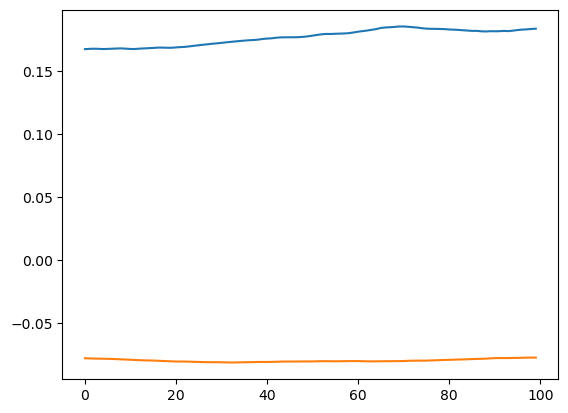

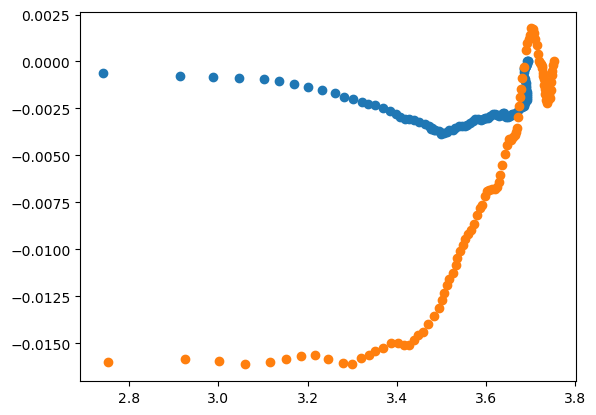

In [34]:
plt.plot(f[:,0])
plt.plot(f[:,1])
plt.show()
plt.scatter(p[:,1],f[:,1]-f[-1,1])
plt.scatter(p[:,0],f[:,0]-f[-1,0])

In [198]:
test1.zwanzig_formula()[0:2]

(0.1671042934184375, -0.07789497250096723)

In [197]:
test1.calc_PiScore()

((3.8809600683412144+0j), (3.8241173671723714+0j))

In [143]:
for e in [1000, 10000, 100000, 500000]:
    print(test1.zwanzig_formula()[:2])

(0.1671042934184375, -0.07789497250096723)
(0.1671042934184375, -0.07789497250096723)
(0.1671042934184375, -0.07789497250096723)
(0.1671042934184375, -0.07789497250096723)


In [145]:
W_AB,W_BA

(array([0.08691451, 0.08705308, 0.09064556, ..., 0.23591312, 0.23741738,
        0.22633942]),
 array([-0.08691451, -0.0896888 , -0.09085899, ..., -0.04841459,
        -0.04996493, -0.04388209]))

In [90]:
%%time 
np.loadtxt()

CPU times: user 1.93 s, sys: 139 ms, total: 2.07 s
Wall time: 11.3 s


array([[ 1.08000000e+03,  2.21196334e+00,  2.28194113e+00, ...,
        -3.03738460e+00,  1.29345359e+00, -3.06600868e+00],
       [ 1.08020000e+03,  2.23115421e+00,  2.24770924e+00, ...,
        -3.03094257e+00,  1.28753930e+00, -3.06668315e+00],
       [ 1.08040000e+03,  2.23915977e+00,  2.28231326e+00, ...,
        -3.06118258e+00,  1.30578232e+00, -3.08232673e+00],
       ...,
       [ 2.01079400e+05,  1.90454768e+00,  1.38624116e+00, ...,
        -2.92278940e+00,  1.51858946e+00, -2.92192001e+00],
       [ 2.01079600e+05,  1.91891638e+00,  1.34866333e+00, ...,
        -2.94542959e+00,  1.51767065e+00, -2.92572502e+00],
       [ 2.01079800e+05,  1.86116630e+00,  1.36441222e+00, ...,
        -2.97565686e+00,  1.53004746e+00, -2.92782659e+00]])

In [94]:
%%time 


CPU times: user 1.82 s, sys: 267 ms, total: 2.09 s
Wall time: 11.3 s


array([2.21196334, 2.21292911, 2.23770348, ..., 2.99673024, 3.00308604,
       2.95579552])

CPU times: user 4.49 s, sys: 292 ms, total: 4.78 s
Wall time: 23.8 s


<BarContainer object of 500 artists>

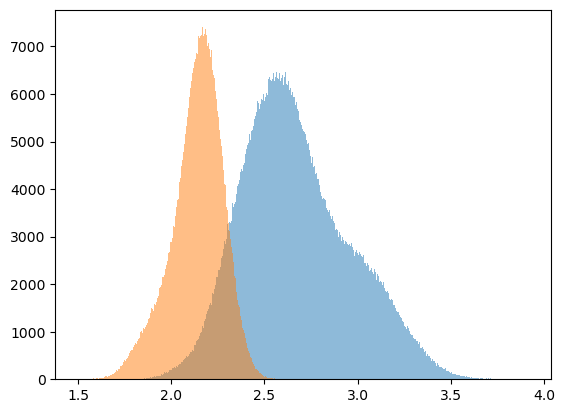

In [87]:
%%time
plt.hist(np.loadtxt('../_sim/01_TIP3P_med_site/_output/pmd_.txt', usecols=1), bins=500,alpha=0.5)[2]
plt.hist(np.loadtxt('../_sim/01_TIP3P_med_site/_output/pmd_p.txt', usecols=1), bins=500,alpha=0.5)[2]

CPU times: user 6.89 s, sys: 521 ms, total: 7.41 s
Wall time: 24.4 s


<BarContainer object of 500 artists>

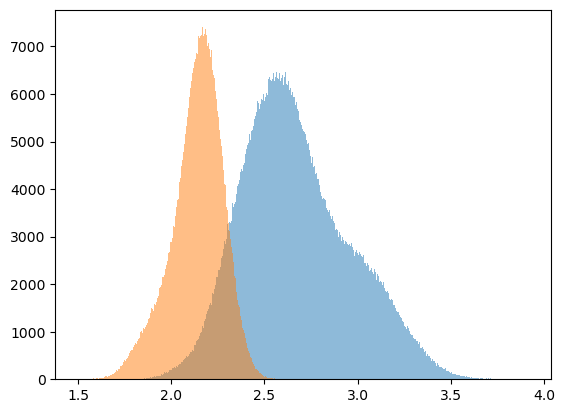

In [83]:
%%time
plt.hist(pd.read_csv('../_sim/01_TIP3P_med_site/_output/pmd_.txt', comment='#', delim_whitespace=True, header=None, index_col=0).iloc[:,0].values, bins=500,alpha=0.5)[2]
plt.hist(pd.read_csv('../_sim/01_TIP3P_med_site/_output/pmd_p.txt', comment='#', delim_whitespace=True, header=None, index_col=0).iloc[:,0].values, bins=500,alpha=0.5)[2]

In [53]:
df.protein.values[0:2]

array([2.21196334, 2.21292911])

In [12]:
columns=['protein', 'nucleic', 'Theta','Phi','Psi','theta','phi']
df = pd.read_csv('../_sim/01_TIP3P_med_site/_output/pmd_.txt', comment='#', delim_whitespace=True, header=None, index_col=0)

df.columns=columns

<BarContainer object of 500 artists>

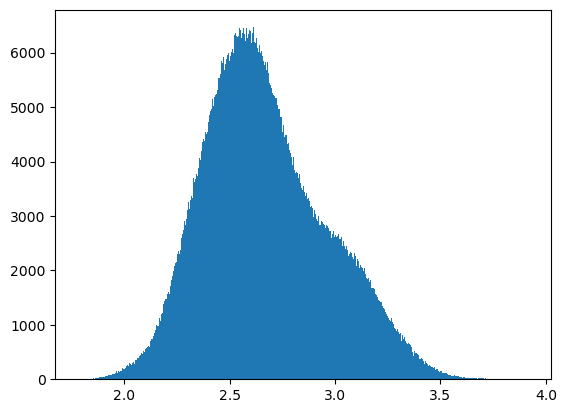

In [60]:
plt.hist(df.protein.values, bins=500)[2]

In [16]:
ref = 1.0
k = 10.0

In [39]:
zwanzig_formula(df.protein.values,T=300,k=10/169)

[0.08691451 0.08705308 0.09064556 ... 0.23591312 0.23741738 0.22633942]


0.1671042934184375